In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

In [2]:
x,y = load_wine(True)

wine = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]), columns = load_wine()['feature_names'] + ['target'])
wine.shape

(178, 14)

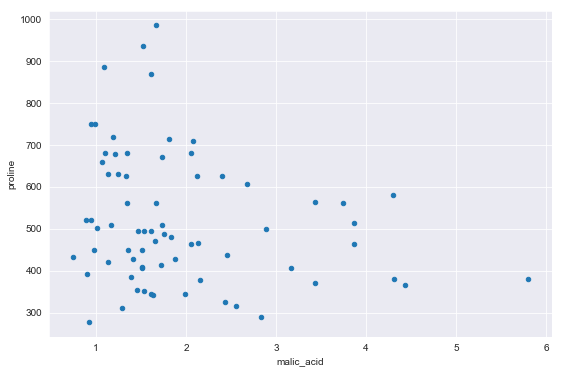

In [3]:
use_ftrs = ['malic_acid', 'proline']
df = wine.loc[wine.target==1,use_ftrs]
df.plot.scatter(*use_ftrs)
    

In [4]:
def plot_covariance(mean_vec, cov):
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ax = df.plot.scatter(*use_ftrs)
    for j in range(1, 4):
        ell = Ellipse(xy=mean_vec,
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), 
                      color= 'teal', linestyle='--', alpha=0.7)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.xlim(0, 7)
    plt.ylim(100,1100)

#### Empirical Covariance

Plot 3 stds of the 2D Distribution

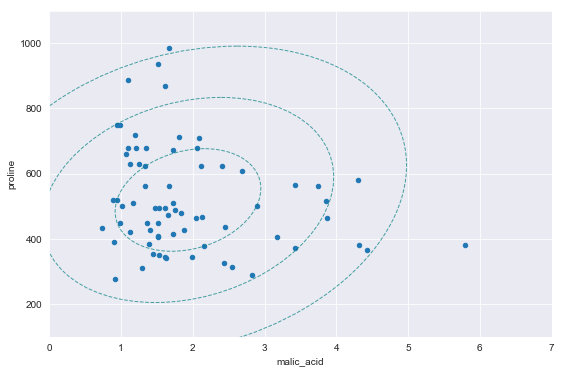

In [39]:
# Plot ellipsoids to illustrate std deviations 
# fromt the mean
mn = df.mean()
cov = df.cov()
plot_covariance(mn, cov)

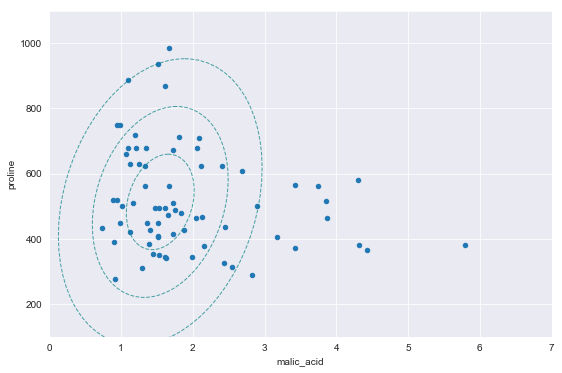

In [40]:
# With Robust Covariance
mcd = MinCovDet(random_state = 1111)
mcd.fit(df)

rmn = mcd.location_
rcov = mcd.covariance_
plot_covariance(rmn, rcov)

Fraction: 0.1
Num Points Used: 67

Fraction: 0.5
Num Points Used: 63

Fraction: 0.9
Num Points Used: 64



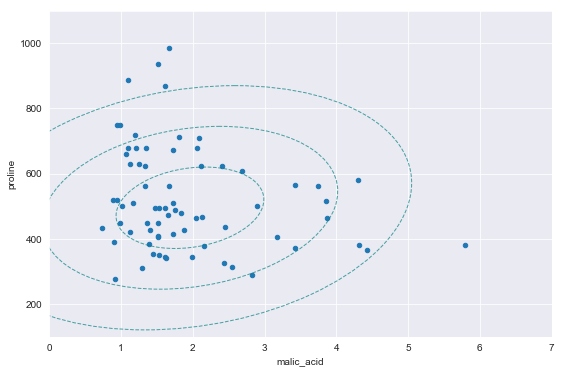

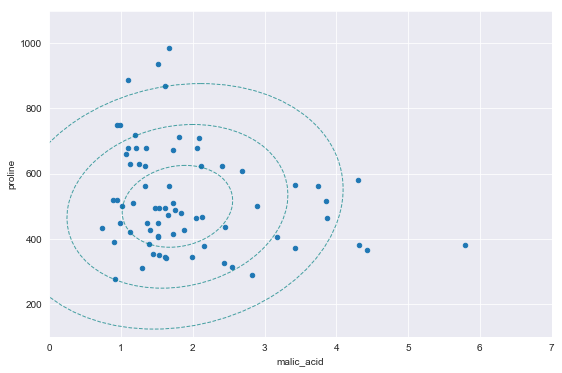

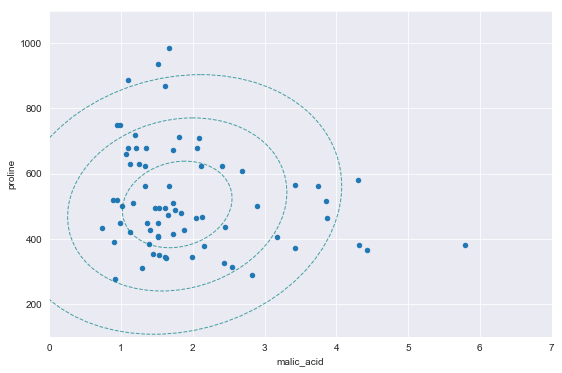

In [82]:
# I don't really understand how support fraction works here...
for frac in [0.1,0.5,0.9]:
    print('Fraction:', frac)
    mcd = MinCovDet(random_state = 1111, support_fraction=frac)
    mcd.fit(df)

    rmn = mcd.location_
    rcov = mcd.covariance_
    print('Num Points Used:', mcd.support_.sum())
    print()
    plot_covariance(rmn, rcov)

Initial Determinant: 14544.42174946404
New Determinant 1375.6123849828998
New Determinant 806.3038035097605
New Determinant 798.716004095763
New Determinant 798.7160040957623
Initial Determinant: 17867.48088690983
New Determinant 2152.6899318318306
New Determinant 960.4551876292957
New Determinant 795.1456041020185
New Determinant 795.1456041020185
Initial Determinant: 17451.172976576567
New Determinant 1882.921941147397
New Determinant 1203.5910932995496
New Determinant 934.7823468635302
New Determinant 795.1456041020185
New Determinant 795.1456041020185


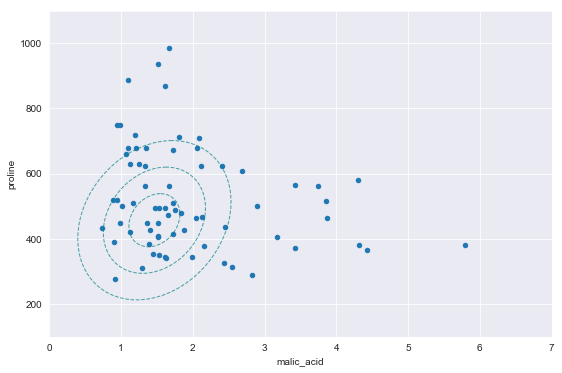

In [86]:
def min_cov_det(df, n_points=None, n_start=3):
    """
    Implementation of finding the Minimum Covariance Determinant estimate of a dataset
    for robust mean and covariance estimates.
    """
    n_points = n_points or int((sum(df.shape) + 1)/2)
    
    best = None
    for i in range(n_start):
        samp = df.sample(n_points)
        raw_mean, raw_cov = samp.mean(), samp.cov()
    
        # first iteration
        curr_mean, curr_cov = raw_mean, raw_cov
        curr_determinant = np.linalg.det(curr_cov)
        print("Initial Determinant:", curr_determinant)

        while True:
            # calculate mahalanobis distances from current mean using current cov for all samples
            dists = np.asarray([mahalanobis(row, curr_mean, np.linalg.inv(curr_cov)) for row in df.values])
            # take the smallest n_points points
            curr_idx = np.argsort(dists)[:n_points]
            # calculate new mean and covariance
            curr_mean, curr_cov = df.iloc[curr_idx].mean(), df.iloc[curr_idx].cov()
            new_determinant = np.linalg.det(curr_cov)
            print('New Determinant', new_determinant)
            # check stopping conditions
            if new_determinant > curr_determinant:
                print('New Determinant', new_determinant, "is greater than old determinant", curr_determinant)
            if np.isclose(new_determinant, 0, atol=0.001):
                best = curr_mean, curr_cov, curr_idx
                break
            elif np.isclose(curr_determinant-new_determinant, 0):
                best = curr_mean, curr_cov, curr_idx
                break
            curr_determinant = new_determinant
    return best
        
new_mn, new_cov, idx = min_cov_det(df)
plot_covariance(new_mn, new_cov)

N Points: 10
---------------
Initial Determinant: 24984.052189135808
New Determinant 80.96271111111115
New Determinant 10.454799999999992
New Determinant 5.446381234567901
New Determinant 5.446381234567901
Initial Determinant: 15771.513243703703
New Determinant 75.04281901234566
New Determinant 60.168763209876396
New Determinant 49.009896543209834
New Determinant 39.43280395061734
New Determinant 39.43280395061734
Initial Determinant: 9082.76828493826
New Determinant 92.04763654320986
New Determinant 51.82609975308643
New Determinant 35.54454716049382
New Determinant 35.54454716049382

N Points: 30
---------------
Initial Determinant: 30247.495068727676
New Determinant 1583.6024664050735
New Determinant 804.5142056440753
New Determinant 461.8840150614348
New Determinant 422.4450644153786
New Determinant 390.00816332936984
New Determinant 390.00816332936984
Initial Determinant: 22179.05890848988
New Determinant 1369.9656822671423
New Determinant 804.5142056440753
New Determinant 461.884

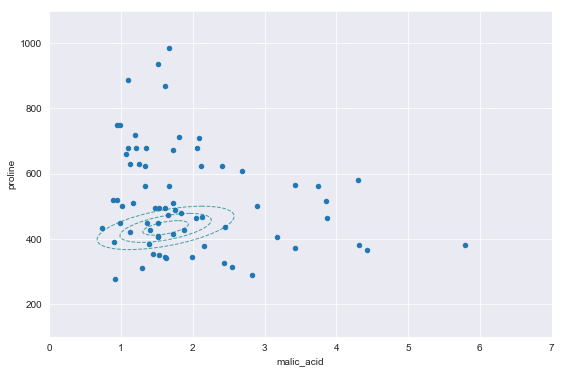

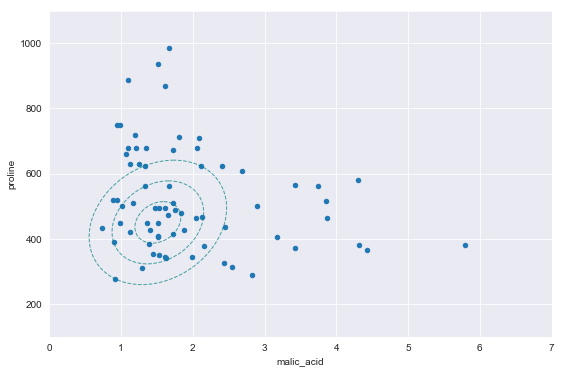

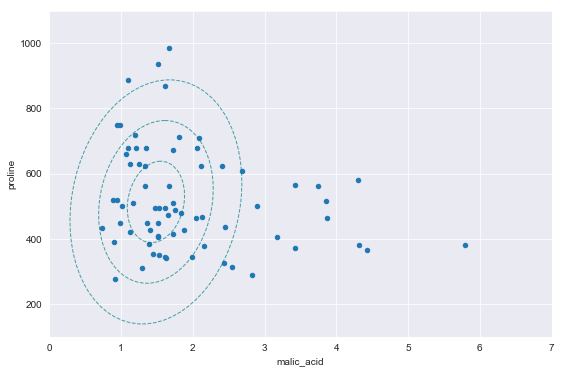

In [90]:
# however in my version, the n_samples does have a large effect (as expected...?)
# I don't really understand how support fraction works here...
for npt in [10,30,50]:
    print('N Points:', npt)
    print('---------------')
    

    new_mn, new_cov, idx = min_cov_det(df,n_points=npt)
    plot_covariance(new_mn, new_cov)
    print()